In [5]:
%matplotlib inline

from IPython.core.display import HTML
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from scipy import cluster
import numpy as np
import pandas as pd
import seaborn as sns
import os
from itertools import product
#import survey_utils

np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

/Users/paepcke/anaconda2/envs/women_tech/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [1]:
# Variables to control details:

# Percentile cutoff in number of zeroes respondents
# are allowed to have before being discarded. Number
# controls place in sorted list of respondents' number of
# zeroes:
#
#    respondent10   4
#    respondent36   6
#    respondent2    10
#      ...
# Only respondents below <respondent_cutoff>% of the length of this
# list are included:

respondent_cutoff = 0.60
if respondent_cutoff > 1.0:
    raise ValueError('Respondent cutoff must be between 0 and 1')
    
# The 'k' in k-means clustering:
num_clusters = 5

In [ ]:
# Variables holding different cuts of the responses:

# qs          all slider and likert questions. Questions are rows, respondents are columns
# good_qs     Like qs, non-serious respondents excluded
# qs_sliders  Like good_qs, but only slider responses, and output-var questions omitted

# obs         all slider and likert questions. Respondents are rows, questions are columns
#             This is the classic rows-are-observations format
# good_obs    Like obs, but with non-serious respondents excluded
# obs_sliders Like good_obs, but only slider responses, and output-var questions omitted


In [2]:
html_str = """
<h1>Analysis Including Only Serious Respondents</h1>
<p>
<div class="explanation">
This analysis includes all slider and likert questions. But only
'serious' respondents are included. Seriousness was measured by
how many zeroes a respondent left. Serious respondents left at most
as many zeroes as %s%% of all respondents. 
<p>
Three alternatives are presented for combining questions:
<ul>
<li>Pairwise correlations are computed from the answers to all questions.
These correlations are sorted, highest first. The resulting list can be
considered top to bottom. The lower a question pair is on the list, the
less similar the two questions are in the insights they capture.
</li>
<li>A dendrogram approach that uses the <a href="https://en.wikipedia.org/wiki/Ward%%27s_method">
<i>Ward</i></a> algorithm for creating clusters
of 'related' questions, based on 'similarity' between the answers to those questions.
Similarity is measured by how similar the variances in the answers to the two questions are.</li>
<li>A dendrogram approach using the <a href="https://en.wikipedia.org/wiki/UPGMA"><i>UPGMA</i></a>
a.k.a. <i>averaging</i> algorithm.</li> Clusters are formed by minimizing the sum of 
distances between all pairs in one cluster and all pairs in neighboring clusters.
</ul>
The first method is the most direct and understandable.
</div>
""" % (
    100*respondent_cutoff)
HTML(html_str)

NameError: name 'HTML' is not defined

In [3]:
     from IPython.core.display import HTML, display
     HTML("""
         <style>
           h1        {text-align : center}
           .subtitle {text-align : center}
           .explanation {font-size : large; 
                         line-height : 125%;
                        }
           .container { width:100% !important; }
           .highlight { background-color : yellow;}
           hr         { height : 3px;
                        background: black
                      }
         </style>
         """)


In [4]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [6]:
def hasnans(data):
    if isinstance(data, pd.DataFrame):
        return data.isnull().any().any()
    elif isinstance(data, pd.Series):
        return data.isnull().any()
    else:
        return data.isnull()


In [7]:
# Get the slider and likert responses:
data_path = os.path.join(os.getenv("HOME"), 
                        #'Project/WomenIndustrySurveyHolzblatt/Data/DataForClustering/slidersLikertByItem.csv'
                        'Project/WomenIndustrySurveyHolzblatt/Data/DataForClustering/likertSlidersByRespondentUnfolded.csv'
                       )

data = pd.read_csv(data_path, sep=',')
# Make the question column the index, so that
# all operations on the dataframe only address
# the numeric scores:
qs = data.set_index('question')
# Replace 0s with their column's median.
#data = utils.replaceZerosDataFrame(data, direction='row')


In [8]:
# Get metadata for each question: Was it likert or slider?
# Was it an output variable or not?
q_metatdata_path = os.path.join(os.getenv("HOME"), 
                        'Project/WomenIndustrySurveyHolzblatt/Data/DataForClustering/questionMetadata.xlsx'
                       )
qmeta = pd.read_excel(q_metatdata_path)
#          Question        QuestionType  IsOutputVar
# 0    Team|GetsInWay         slider       0
# 1    Team|LooseGroup        likert       0
# 2    Team|Alienated         slider       0

# Make question into the index:
qmeta = qmeta.set_index('Question')
qmeta.head(3)

QuestionType  IsOutputVar
Question                                 
Team|GetsInWay        slider            0
Team|LooseGroup       slider            0
Team|Alienated        slider            0

In [9]:
# Drop all questions (rows) that nobody answered:
qs = qs.loc[~(qs==0).all(axis=1)]

In [10]:
# Drop all participants who answered no questions:
qs = qs[qs.columns[(qs != 0).any()]]

In [11]:
print(' %s percent of the respondents.' % (100*respondent_cutoff))
#print(' %s percent of the respondents.' % 60)

 60.0 percent of the respondents.


In [12]:
html_str  = '<div class="explanation">'
html_str += "Find respondents who answered 'most' questions. Method: "
html_str += 'Count the number of zeroes in the answers of every respondent. Sort '
html_str += 'the respondents in increasing order of those zero-responses. '
html_str += 'Accept the first '
html_str += ' %s percent of the respondents.' % (100*respondent_cutoff)
html_str += '</div>'

HTML(html_str)


<div class="explanation">Find respondents who answered 'most' questions. Method:
Count the number of zeroes of every respondent. Sort
those numbers in increasing order. Accept the first
75% of the respondents (can change that cutoff above).
</div>

In [13]:
# Get number of zeroes for each respondent,
# sorted ascending :
#   s14 12
#   s3  14
#   s18 15
respondent_zeroes = qs[qs == 0].count().sort_values(ascending=True)
#num_zeroes.head(20)
# Get array of respondent IDs to include: take the
# first <respondent_cutoff> percent of the sorted
# list:
index_to_cutoff = int(np.floor(respondent_cutoff*len(respondent_zeroes)))
# ... and keep only the lower part:
respondents_to_use = respondent_zeroes[:index_to_cutoff].index


In [14]:
html_str = '<div class="explanation">'

html_str  = 'Number of likert/slider questions: <span class="highlight">%s</span><br>' % len(qs)
html_str += 'Median number of unanswered questions all respondents: %s<br>' % respondent_zeroes.median()
html_str += 'Mean number of unanswered questions all respondents: %s<br>' % respondent_zeroes.mean()
html_str += 'Max number of unanswered questions all respondents: %s<br>' % respondent_zeroes[-1]
html_str += '<br>'
html_str += 'Number of all respondents: %s<br>' % len(respondent_zeroes)

html_str += '<br>'

html_str += 'For %sth percentile respondents:' % int(respondent_cutoff*100)
html_str += 'Median number of unanswered questions for selected respondents: %s<br>' % respondent_zeroes[:index_to_cutoff].median()
html_str += 'Mean number of unanswered questions: %s<br>' % respondent_zeroes[:index_to_cutoff].mean()
html_str += 'Max number of unanswered questions: %s<br>' % respondent_zeroes[index_to_cutoff]
html_str += 'Number of accepted respondents: <span class="highlight">%s</span><br>' % len(respondents_to_use)

html_str += '</div>'

HTML(html_str)


In [15]:
# Get new variables for the rows-are-questions
# and rows-are-respondents that include only 
# the respondents we want to use:
good_qs  = qs[respondents_to_use]

# Turn nums into floats for later use:
good_qs = good_qs.astype(np.float)
good_obs = good_qs.transpose()


<h2>Correlation Matrix Method for Finding Similar Questions</h2>

In [16]:
# Get correlations between the answers to each pair of questions:
corr_matrix = good_obs.corr()
#corr_matrix.head(3)


In [17]:
# Get rid of the upper-right triangle of the correlation matrix:

#array([[ True, False, False],
#       [ True,  True, False],
#       [ True,  True,  True]], dtype=bool)

corr_matrix_tri_lower_mask = np.tril(np.ones(corr_matrix.shape).astype(np.bool))
#corr_matrix_tri_lower

# Use this mask to turn upper triangle into NaNs:
corr_matrix_tri_lower = corr_matrix.where(corr_matrix_tri_lower_mask)

corr_matrix_tri_lower.head(4)

question                            PersonalExperience|ILackConfidence  \
question                                                                 
PersonalExperience|ILackConfidence                            1.000000   
WorkLife|ReceivedBadReview                                    0.426972   
Experience|Bored                                             -0.462470   
Feel|ValuedByManager                                         -0.245666   

question                            WorkLife|ReceivedBadReview  \
question                                                         
PersonalExperience|ILackConfidence                         NaN   
WorkLife|ReceivedBadReview                            1.000000   
Experience|Bored                                     -0.696466   
Feel|ValuedByManager                                 -0.372418   

question                            Experience|Bored  Feel|ValuedByManager  \
question                                                                     
PersonalExperience|ILackConfidence               NaN                   NaN   
WorkLife|ReceivedBadReview                       NaN                   NaN   
Experience|Bored                            1.000000                   NaN   
Feel|ValuedByManager                        0.732329                   1.0   

question                            Power|HaveSelfConfidence  Team|GetsInWay  \
question                                                                       
PersonalExperience|ILackConfidence                       NaN             NaN   
WorkLife|ReceivedBadReview                               NaN             NaN   
Experience|Bored                                         NaN             NaN   
Feel|ValuedByManager                                     NaN             NaN   

question                            Team|HoHum  Power|MenGetGoodReactions  \
question                                                                    
PersonalExperience|ILackConfidence         NaN                        NaN   
WorkLife|ReceivedBadReview                 NaN                        NaN   
Experience|Bored                           NaN                        NaN   
Feel|ValuedByManager                       NaN                        NaN   

question                            Promoted|DontWantClimb  \
question                                                     
PersonalExperience|ILackConfidence                     NaN   
WorkLife|ReceivedBadReview                             NaN   
Experience|Bored                                       NaN   
Feel|ValuedByManager                                   NaN   

question                            Team|PowerStruggles        ...         \
question                                                       ...          
PersonalExperience|ILackConfidence                  NaN        ...          
WorkLife|ReceivedBadReview                          NaN        ...          
Experience|Bored                                    NaN        ...          
Feel|ValuedByManager                                NaN        ...          

question                            Men|MustWorkLonger  Men|GenderNoImpact  \
question                                                                     
PersonalExperience|ILackConfidence                 NaN                 NaN   
WorkLife|ReceivedBadReview                         NaN                 NaN   
Experience|Bored                                   NaN                 NaN   
Feel|ValuedByManager                               NaN                 NaN   

question                            Team|Alienated  Men|WomenAlsoInterrupt  \
question                                                                     
PersonalExperience|ILackConfidence             NaN                     NaN   
WorkLife|ReceivedBadReview                     NaN                     NaN   
Experience|Bored                               NaN                     NaN   
Feel|ValuedByManager                           NaN

<h3>Flatten matrix into a one-column DataFrame, then sort by decreasing correlation:</h3>

In [18]:
row_name_series = pd.Series(corr_matrix_tri_lower.index.values)
col_name_series = pd.Series(corr_matrix_tri_lower.columns.values)
# Get: Series([(SurveyItem1, SurveyItem1),
#              (SurveyItem1, SurveyItem2),
#              (SurveyItem1, SurveyItem3),
#              (SurveyItem2, SurveyItem1),
#              (SurveyItem2, SurveyItem2),
#              (SurveyItem2, SurveyItem3),
#                     ...
#            ])
all_cell_names  = pd.Series(list(product(row_name_series, col_name_series)))
#all_cell_names

# Flatten the correlation matrix into a 1-column DF:
corrs_df = pd.DataFrame(corr_matrix_tri_lower.values.flatten(), index=all_cell_names, columns=['Correlations'])

# Remove the diagonal 1s entries: 

# Currently the question-pairs are the index. Turn them into a 
# second column named 'Questions':
#                   	Questions                       	Correlations
#    0 	(PersonalExperience|ILackConfidence, PersonalE... 	1.000000
#    1 	(PersonalExperience|ILackConfidence, WorkLife|... 	0.620947

corrs_df = corrs_df.reset_index().rename(columns={'index' : 'Questions'})
corrs_df = corrs_df.where(corrs_df.Questions.apply(lambda x: x[0] != x[1])).dropna()
#corrs_df

# Sort by descending correlation:
# 	Questions 	Correlations
#9404 	(Team|NotPartOfGrp, Manager|HesitateToTakeChal... 	1.000000
#9755 	(Manager|HesitateToTakeChallenges, Team|NotPar... 	1.000000
#     ...
#2840 	(Promoted|UnsureWhatToDo, Promoted|DontWantClimb) 	0.995508
#968 	(Promoted|DontWantClimb, Promoted|UnsureWhatToDo) 	0.995508
#5330 	(Balance|ManagerSendsHome, Balance|CultureSupp... 	0.994896
#2405 	(Balance|CultureSupportive, Balance|ManagerSen... 	0.994896
#     ...
         
corrs_df.sort_values(by='Correlations', ascending=False, inplace=True)
#corrs_df
#len(corrs_df)

In [19]:
html_str = '<span class="highlight">Number of pairwise correlations: %s</span>' % len(corrs_df)
HTML(html_str)

<div class="explanation">List of pairwise correlations in descending order:</div>

In [20]:
# Print list of sorted correlations:
cm = sns.light_palette("green", as_cmap=True)

styled_corrs_df = corrs_df.style.background_gradient(cmap=cm)
styled_corrs_df

<hr>

<h2>Dendrogram Method Using Ward for Clustering</h2>
<div class="explanation">This method finds cluster members by grouping those questions that had very similar variances.
</div>

(Note: more readable question layout further down)


In [21]:
# Find the best algorithm for dendrogram clustering. Supposedly
# the algorithm with the largest Cophenet correlation coefficient
# tends to be best:

# Cophenet correlation coefficient measures 
# how faithfully a dendrogram preserves pairwise
# distance between the original data points, use
# the algo that yields the highest coefficient:

max_c = 0
max_algo = ''
max_cluster_info = None
algo_results = {}
for algo in ['ward', 'centroid', 'weighted', 'average', 'complete', 'single']:
    cluster_info = linkage(good_qs, algo)
    (c, coph_dists) = cophenet(cluster_info, pdist(good_qs))
    if c > max_c:
        max_c = c
        max_algo = algo
        max_cluster_info = cluster_info
    algo_results[algo] = {'cophenet_coeff' : c,
                          'cluster_info' : cluster_info
                          }
print("Winning Cophenet correlation coefficient is the '%s' algorithm: %s" % (max_algo, max_c))
# cluster_info = max_cluster_info
# algo = max_algo
print("... but using Ward (c= %s)" % algo_results['ward']['cophenet_coeff'])

algo = 'ward'
cluster_info = algo_results[algo]['cluster_info']


Winning Cophenet correlation coefficient is the 'average' algorithm: 0.859306745072
... but using Ward (c= 0.632157505877)


In [22]:
#good_obs.head(4)
#len(cluster_info) # 115
#cluster_info[0]   # array([ 37.,  79.,  17.,   2.])

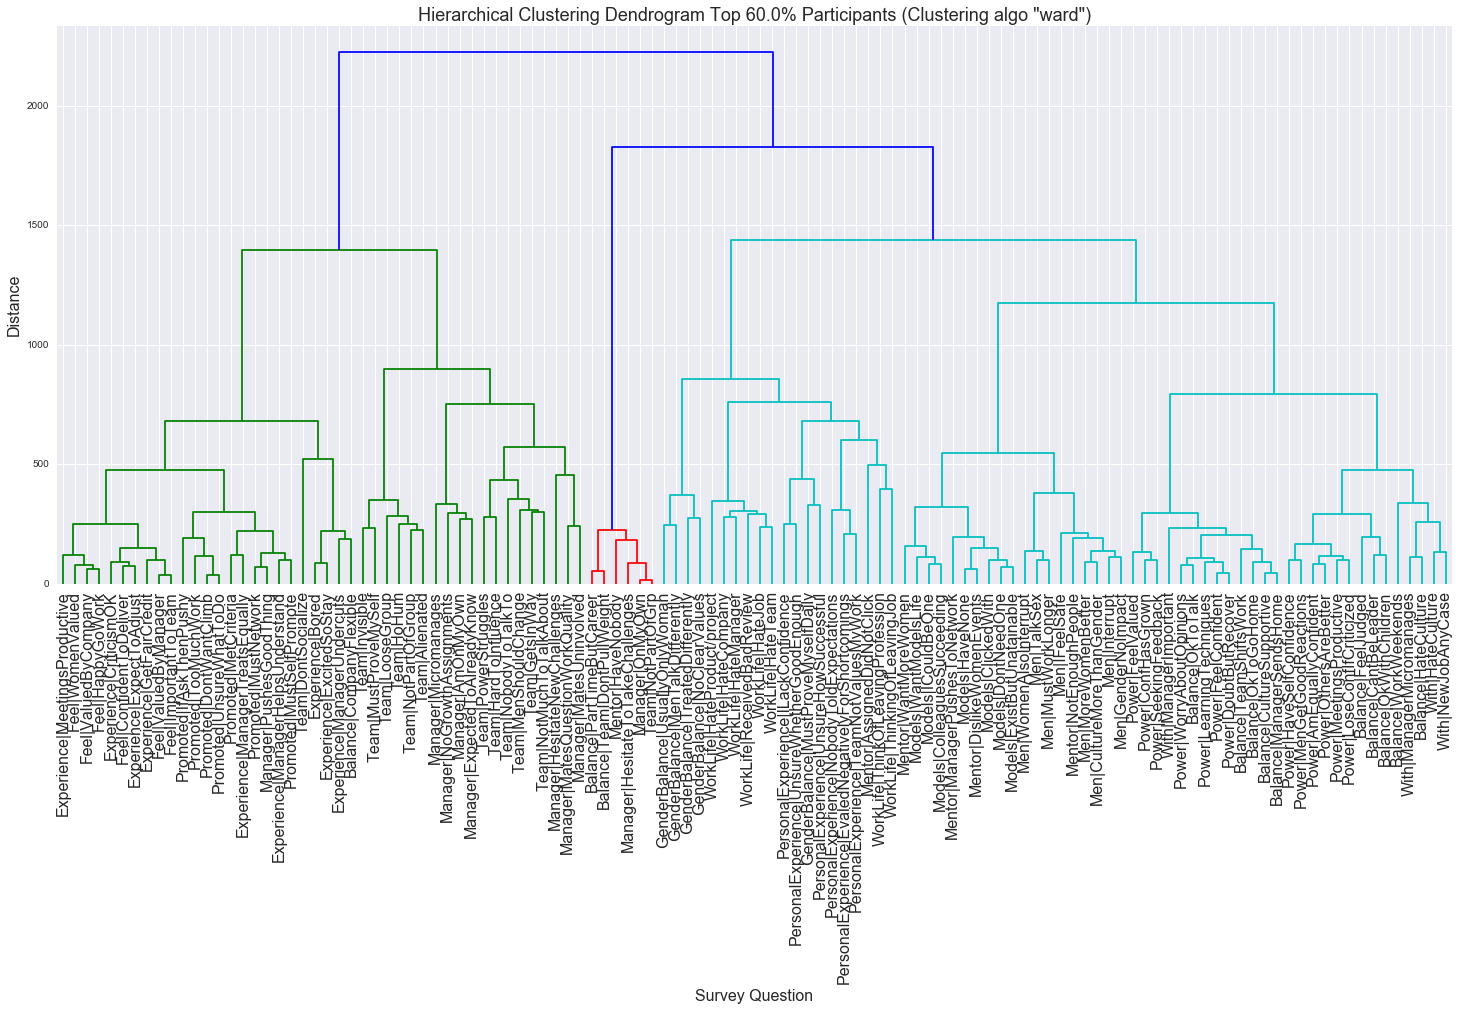

In [23]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
title = 'Hierarchical Clustering Dendrogram Top %s%% Participants (Clustering algo "%s")' % (100*respondent_cutoff, algo)
plt.title(title, fontsize=18)
plt.xlabel('Survey Question', fontsize=16)
plt.ylabel('Distance', fontsize=16)
dendrogram_data = dendrogram(
        algo_results[algo]['cluster_info'],
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=16.,  # font size for the x axis labels
        labels=good_qs.index
)
plt.show()



<div class="explanation">Make groups more readable:</div>

In [48]:
# Build a DataFrame that combines question, distance, and color.
# Then change the names of the one-letter colors to more readable
# expanded form:
clusters = zip(dendrogram_data['ivl'], dendrogram_data['leaves'], dendrogram_data['color_list'])
clusters = pd.DataFrame(clusters, columns=['Question', 'Distance', 'Color'])
clusters['Color'].replace(['g','r','b','c','m','y','k'], 
                          ['green','red','blue','cyan','magenta','yellow','black'],
                          inplace=True
                          )

# Save the Ward-based clusters for later:
ward_clusters = clusters.copy()
# Turn the 'Question' column into the index:
ward_clusters = ward_clusters.set_index('Question')

def cluster_table_styler(val):
    if val == 'green':
        return("background-color : green")
    elif val == 'red':
        return("background-color : red")
    elif val == 'blue':
        return("background-color : blue")
    elif val == 'cyan':
        return("background-color : cyan")
    elif val == 'magenta':
        return("background-color : magenta")
    elif val == 'yellow':
        return("background-color : yellow")
    elif val == 'black':
        return("background-color : black")
    else:
        return ''
    
clusters.style.applymap(cluster_table_styler)



<hr>

<h2>Alternative Dendrogram: using highest-cophenet-coefficient algorithm ('average'):</h2>
<div class="explanation">
The <i>average</i> clustering method minimizes the average distance between any two elements of neighboring clusters.
The method is also known as UPGMA <b>U</b>nweighted <b>P</b>air <b>G</b>roup <b>M</b>ethod with <b>A</b>rithmetic <b>M</b>ean.
</div>

In [26]:
def print_and_color(k):
    print(k)
    return 'Coral'

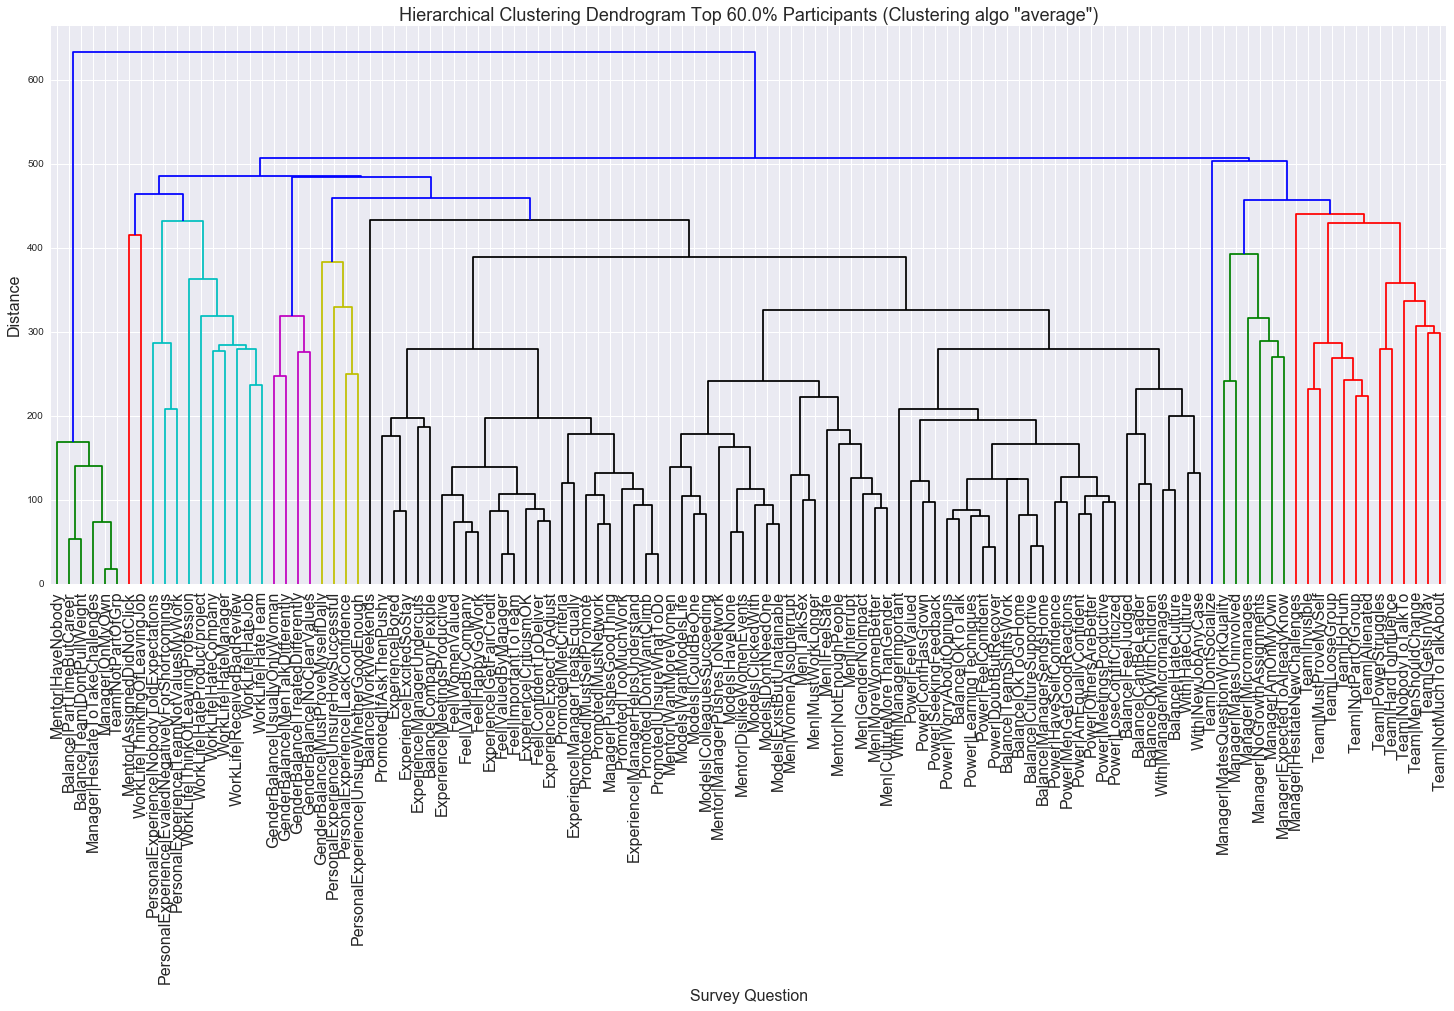

In [27]:
algo = max_algo

# calculate full dendrogram
plt.figure(figsize=(25, 10))
title = 'Hierarchical Clustering Dendrogram Top %s%% Participants (Clustering algo "%s")' % (100*respondent_cutoff, algo)
plt.title(title, fontsize=18)
plt.xlabel('Survey Question', fontsize=16)
plt.ylabel('Distance', fontsize=16)
dendrogram_data = dendrogram(
        algo_results[algo]['cluster_info'],
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=16.,  # font size for the x axis labels
        labels=good_qs.index,  # question names
)
plt.show()



<div class="explanation">
Make groups easier to read:
</div>

In [28]:
# Build a DataFrame that combines question, distance, and color.
# Then change the names of the one-letter colors to more readable
# expanded form:
clusters = zip(dendrogram_data['ivl'], dendrogram_data['leaves'], dendrogram_data['color_list'])
clusters = pd.DataFrame(clusters, columns=['Question', 'Distance', 'Color'])
clusters['Color'].replace(['g','r','b','c','m','y','k'], 
                          ['green','red','blue','cyan','magenta','yellow','black'],
                          inplace=True
                          )

def cluster_table_styler(val):
    if val == 'green':
        return("background-color : green")
    elif val == 'red':
        return("background-color : red")
    elif val == 'blue':
        return("background-color : blue")
    elif val == 'cyan':
        return("background-color : cyan")
    elif val == 'magenta':
        return("background-color : magenta")
    elif val == 'yellow':
        return("background-color : yellow")
    elif val == 'black':
        return("background-color : black")
    else:
        return ''

# Save 'average'-generated clusters for later:
average_clusters = clusters.copy()
# Turn the 'Question' column into the index:
average_clusters = average_clusters.set_index('Question')

clusters.style.applymap(cluster_table_styler)

<hr>

<h2>Cluster using K-Means, and plot some questions from the above groupings.</h2>
<div class="explanation">
Use only the slider responses, because they are truly continuous. 
Also, at this point: leave out the questions we will use as output variables
to be predicted further down.
</div>

In [29]:
# Get question-in-rows data with two
# additional columns: QuestionType and IsOutputVar.
# Both are from the qmeta table:
#                               s100   s98    s97    QuestionType  IsOutputVar
# Balance|CantBeLeader            87.0   87.0   87.0    likert           0
# Balance|CompanyFlexible         62.0   62.0   62.0    likert           0
# Balance|CultureSupportive       87.0   87.0   87.0    likert           0
#
# We'll use that to pull out only the slider questions
# that are not also output variables:

good_qs_meta = good_qs.join(qmeta)
#good_qs_meta.head(3)
# Do the row selection, then drop the 'QuestionType' and 'IsOutputVar' cols:

qs_sliders  = good_qs_meta.loc[(good_qs_meta['QuestionType'] == 'slider') & (good_qs_meta['IsOutputVar'] == 0)]
qs_sliders  = qs_sliders.drop('QuestionType', axis=1).drop('IsOutputVar', axis=1)
obs_sliders = qs_sliders.transpose()
#qs_sliders.head(3)


Compute clusters for k=1 to k=10. Plot the resulting 
overall distortion for each k. Then pick a k where
the curve has an 'elbow'. Our case, 4 clusters is an option:

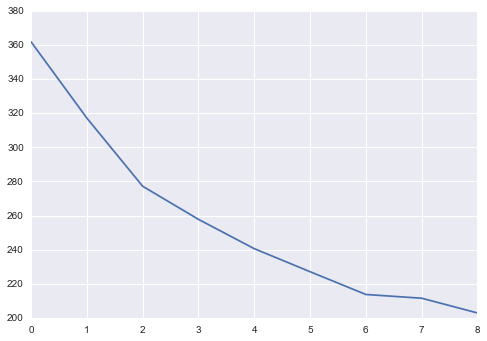

In [30]:
# Get clustering for k=1 to k=10 to see where distortion levels out:
initial = [cluster.vq.kmeans(qs_sliders, k) for k in range(1,10)]
#initial
plt.plot([distortion for (centroids, distortion) in initial])

<div class="explanation">
In the following: modify statements <br>
<code>questions_cluster_1 = green_ward_questions</code> and<br>
<code>questions_cluster_2 = cyan_ward_questions</code>
<p>
to sample questions from different clusters of the Ward dendrogram.
Options are <i>green, red, cyan, blue, and magenta</i>.
</div>


In [70]:
#70*len(questions_cluster_1)/100
len(qs_sliders.columns)
int(70*len(qs_sliders.columns)/100)
len(good_cluster1_responses)

1

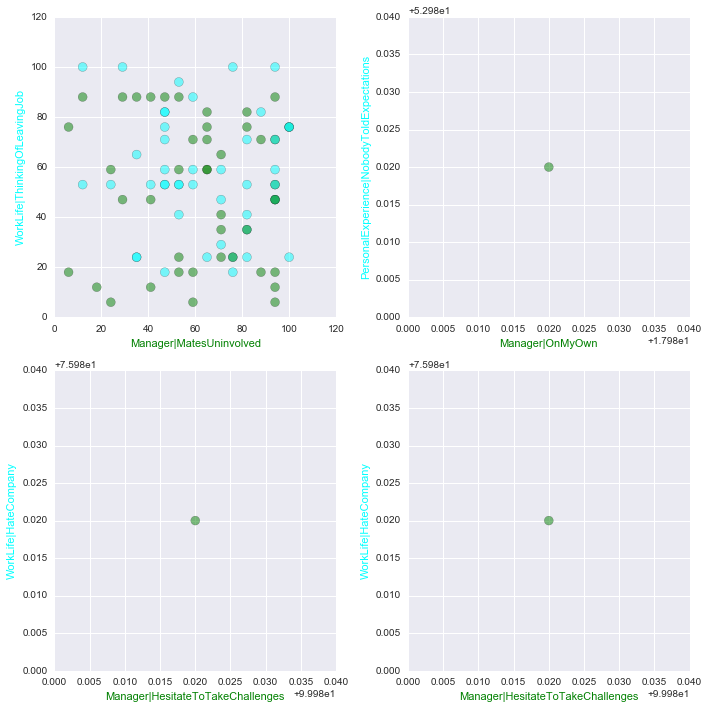

In [74]:
# Number of clusters is in num_clusters, set at the top.

cluster1_color = 'green'
cluster2_color = 'cyan'

(centroids, distortion) = initial[num_clusters - 1]

# Get as many colors as we have clusters:

number_of_colors = num_clusters
cm_subsection = np.linspace(0, 1, number_of_colors) 
accent_cmap = plt.cm.get_cmap('Accent')
colors = [ accent_cmap(x) for x in cm_subsection ]


# Assign each observation to one cluster:
(centroid_assignments, distortions) = cluster.vq.vq(qs_sliders, centroids)

# Get arrays of questions from the Ward clusters.
# But we only want the slider questions among those
# We'll then plot pairs of response vectors to random question pairs
# below:
ward_cluster_qs = {
    'green': ward_clusters[ward_clusters.Color == 'green'].index.intersection(qs_sliders.index),
    'red'  : ward_clusters[ward_clusters.Color == 'red'].index.intersection(qs_sliders.index),
    'cyan' : ward_clusters[ward_clusters.Color == 'cyan'].index.intersection(qs_sliders.index),
    'blue' : ward_clusters[ward_clusters.Color == 'blue'].index.intersection(qs_sliders.index),
    'magenta' : ward_clusters[ward_clusters.Color == 'magenta'].index.intersection(qs_sliders.index)
}

# Number of plots with different questions on x/y axes:
num_plots = 4
plot_cols = 2
plot_rows = int(np.ceil(num_plots / plot_cols))

# The axes_arr will have same shape as
# arrangement of plots: E.g. 3x2:
(fig, axes_arr) = plt.subplots(plot_rows,plot_cols)
axes = axes_arr.flatten()
fig.set_size_inches(10,10)

# Pick two clusters from which questions will be drawn:
questions_cluster_1 = ward_cluster_qs[cluster1_color]
questions_cluster_2 = ward_cluster_qs[cluster2_color]

for i in range(num_plots):
    
    # For each plot, find a pair of questions that
    # at least 70% of the respondents answered. Try
    # 40 pairs. If none found then, leave plot blank:
    for find_qpair_attempt in range(40):
        cluster1_question = np.random.choice(questions_cluster_1)
        cluster2_question   = np.random.choice(questions_cluster_2)

        # Get responses to the two sample questions by all respondents:
        cluster1_responses      = qs_sliders.loc[cluster1_question]
        cluster2_responses      = qs_sliders.loc[cluster2_question]

        # Discard all respondents that did not answer *either*
        # question:    
        cluster1_non_responders = cluster1_responses.loc[cluster1_responses == 0]
        cluster2_non_responders = cluster2_responses.loc[cluster2_responses == 0]

        non_responders_either_q = cluster1_non_responders.index.union(cluster2_non_responders.index)

        # The remaining responses:
        good_cluster1_responses = cluster1_responses.drop(non_responders_either_q)
        good_cluster2_responses = cluster2_responses.drop(non_responders_either_q)

        # If too few responses are left, b/c most respondents did not
        # answer one of the two questions, then move on:
        if len(good_cluster1_responses) < int(70*len(qs_sliders.columns)/100):
            # Pick another pair of questions:
            continue

    the_plot = axes[i]
    the_plot.scatter(good_cluster1_responses, 
                     good_cluster2_responses,
                     c=[cluster1_color, cluster2_color],
                     cmap=accent_cmap,
                     s=80,
                     alpha=0.5
                    ) # dot size
    the_plot.set_xlabel(cluster1_question, color=cluster1_color)
    the_plot.set_ylabel(cluster2_question, color=cluster2_color)
    
plt.tight_layout()
plt.show()


<hr>

In [ ]:
# Number of clusters is in num_clusters, set at the top.

# Do it again sampling questions from clusters formed
# by the 'average' algo:

(centroids, distortion) = initial[num_clusters - 1]

# Get as many colors as we have clusters:

number_of_colors = num_clusters
cm_subsection = np.linspace(0, 1, number_of_colors) 
accent_cmap = plt.cm.get_cmap('Accent')
colors = [ accent_cmap(x) for x in cm_subsection ]


# Assign each observation to one cluster:
(centroid_assignments, distortions) = cluster.vq.vq(qs_sliders, centroids)

# Get arrays of questions from the Ward clusters.
# But we only want the slider questions among those
# We'll then plot pairs of response vectors to random question pairs
# below:
green_ward_questions = ward_clusters[ward_clusters.Color == 'green'].index.intersection(qs_sliders.index)
red_ward_questions = ward_clusters[ward_clusters.Color == 'red'].index.intersection(qs_sliders.index)
cyan_ward_questions = ward_clusters[ward_clusters.Color == 'cyan'].index.intersection(qs_sliders.index)
blue_ward_questions = ward_clusters[ward_clusters.Color == 'blue'].index.intersection(qs_sliders.index)
magenta_ward_questions = ward_clusters[ward_clusters.Color == 'magenta'].index.intersection(qs_sliders.index)

#green_questions.sample().Question
#print(some_respondents[green_questions.sample().Question])
#green_questions

# Number of plots with different questions on x/y axes:
num_plots = 4
plot_cols = 2
plot_rows = int(np.ceil(num_plots / plot_cols))

# The axes_arr will have same shape as
# arrangement of plots: E.g. 3x2:
(fig, axes_arr) = plt.subplots(plot_rows,plot_cols)
axes = axes_arr.flatten()
fig.set_size_inches(10,10)

# Pick two clusters from which questions will be drawn:
questions_cluster_1 = green_ward_questions
questions_cluster_2 = green_ward_questions

for i in range(num_plots):
    cluster1_question = np.random.choice(questions_cluster_1)
    cluster2_question   = np.random.choice(questions_cluster_2)
    
    # Get responses to the two sample questions by all respondents:
    cluster1_responses      = qs_sliders.loc[cluster1_question]
    cluster2_responses      = qs_sliders.loc[cluster2_question]
    
    # Discard all respondents that did not answer *either*
    # question:    
    cluster1_non_responders = cluster1_responses.loc[cluster1_responses == 0]
    cluster2_non_responders = cluster2_responses.loc[cluster2_responses == 0]

    non_responders_either_q = cluster1_non_responders.index.union(cluster2_non_responders.index)

    # The remaining responses:
    good_cluster1_responses = cluster1_responses.drop(non_responders_either_q)
    good_cluster2_responses = cluster2_responses.drop(non_responders_either_q)

    the_plot = axes[i]
    the_plot.scatter(good_cluster1_responses, 
                     good_cluster2_responses,
                     #c=centroid_assignments, # color by centroid
                     c=colors[0:2],
                     cmap=accent_cmap,
                     s=60
                    ) # dot size
    the_plot.set_xlabel(green_question)
    the_plot.set_ylabel(red_question)
    
plt.tight_layout()
plt.show()


<hr>

In [ ]:
ward_clusters[ward_clusters.Color == 'green']
green_questions = ward_clusters[ward_clusters.Color == 'green']
red_questions = ward_clusters[ward_clusters.Color == 'red']
cyan_questions = ward_clusters[ward_clusters.Color == 'cyan']
blue_questions = ward_clusters[ward_clusters.Color == 'blue']

In [ ]:
ward_questions = ward_clusters['Question'].iloc[:31]
len(ward_questions)
#plt.plot(data[ward_questions])
some_respondents = good_obs.copy().ix[ward_questions].reset_index().rename(columns={'index' : 'Question'})
some_respondents = some_respondents.rename(columns={'question' : 'Question'})
thin_ward_clusters = ward_clusters[['Question', 'Color']].set_index('Question')
thin_some_respondents = some_respondents.set_index('Question')
thin_some_respondents = thin_some_respondents.join(thin_ward_clusters, how='inner')
#thin_some_respondents
#thin_ward_clusters


In [ ]:
import os
thin_some_respondents.reset_index().to_csv(os.path.join(os.getenv('HOME'), 'tmp/some_respondents.csv'))
thin_some_respondents


In [ ]:
green_ward_questions = ward_clusters[ward_clusters.Color == 'green']
red_ward_questions = ward_clusters[ward_clusters.Color == 'red']
cyan_ward_questions = ward_clusters[ward_clusters.Color == 'cyan']
blue_ward_questions = ward_clusters[ward_clusters.Color == 'blue']
magenta_ward_questions = ward_clusters[ward_clusters.Color == 'magenta']

#*****ward_clusters = ward_clusters.set_index('Question')
green_ward_questions = ward_clusters[ward_clusters.Color == 'green'].index.intersection(qs_sliders.index)

green_ward_questions
#len(ward_clusters[ward_clusters.Color == 'green'])

green_ward_questions = ward_clusters[ward_clusters.Color == 'green'].index.intersection(qs_sliders.index))
red_ward_questions = ward_clusters[ward_clusters.Color == 'red'].index.intersection(qs_sliders.index))
cyan_ward_questions = ward_clusters[ward_clusters.Color == 'cyan'].index.intersection(qs_sliders.index))
blue_ward_questions = ward_clusters[ward_clusters.Color == 'blue'].index.intersection(qs_sliders.index))
magenta_ward_questions = ward_clusters[ward_clusters.Color == 'magenta'].index.intersection(qs_sliders.index))



In [ ]:
green_ward_questions

In [ ]:
np.random.choice(green_ward_questions)